# Import custom images and annotations

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import boto3
import io
import pandas as pd

bucket = 'label-test3'
client = boto3.client('s3')
response = client.list_objects_v2(Bucket=bucket)


## View one of the original raw files

In [2]:
file_name = '0006-0044.png'
#file_name = 'test12/annotations/consolidated-annotation/consolidation-request/iteration-1/2022-02-10_04:51:40.json'
s3_clientobj = client.get_object(Bucket='label-test3', Key=file_name)
s3_clientobj

{'ResponseMetadata': {'RequestId': 'N4QD5XFW0952E1ST',
  'HostId': 'va+liH4Ym5gwvjF2mlMqwZ71MGVMTd5829lgEQwP0GMw+6AkrS2ZWGEB6bUngipSpa/EE5WIbGI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'va+liH4Ym5gwvjF2mlMqwZ71MGVMTd5829lgEQwP0GMw+6AkrS2ZWGEB6bUngipSpa/EE5WIbGI=',
   'x-amz-request-id': 'N4QD5XFW0952E1ST',
   'date': 'Wed, 16 Feb 2022 04:19:06 GMT',
   'last-modified': 'Tue, 15 Feb 2022 21:57:06 GMT',
   'etag': '"e04e8c567f9a188bb064608f007273e9"',
   'accept-ranges': 'bytes',
   'content-type': 'image/jpeg',
   'server': 'AmazonS3',
   'content-length': '332269'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2022, 2, 15, 21, 57, 6, tzinfo=tzutc()),
 'ContentLength': 332269,
 'ETag': '"e04e8c567f9a188bb064608f007273e9"',
 'ContentType': 'image/jpeg',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f75a6a47a50>}

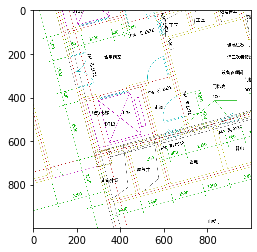

In [3]:
from io import BytesIO
image = mpimg.imread(BytesIO(s3_clientobj['Body'].read()), 'jp2')

plt.figure(0)
plt.imshow(image)


## for each image return the bounding boxes
1. Update input.json 

https://aws.amazon.com/blogs/machine-learning/streamlining-data-labeling-for-yolo-object-detection-in-amazon-sagemaker-ground-truth/

2. Create a csv with each image and annotation

In [32]:
!ipython parse_annot.py s3://label-test3/test12/manifests/output/output.manifest test12


]0;IPython: /root

3. Get bounding boxes for each image

In [48]:
# grab csv from S3 into memory
file_key = "test12/annot.csv"
annot_file = 's3://{}/{}'.format(bucket, file_key)
# df_ann = pd.read_csv(s3uri)
# df_ann.head()

,img_file,category,box_left,box_top,box_height,box_width,img_width,img_height
0,0141-0009.png,Overlapping text,705,416,166,186,1000,1000
1,0141-0014.png,Overlapping text,523,208,126,124,1000,1000


In [49]:
def annot_rcnn(annot_file, cats):
    """
    Prepares the annotation in RCNN format

    Input:
    annot_file: csv file containing Ground Truth annotations
    ordered_cats: List of object categories in proper order for model training

    Returns:
    df_ann: pandas dataframe with the following columns
            img_file int_category box_top box_bottom box_left box_right

    """

    df_ann = pd.read_csv(annot_file)

    df_ann["int_category"] = df_ann["category"].apply(lambda x: cats.index(x))
    df_ann["xmin"] = df_ann["box_top"]
    df_ann["xmax"] = df_ann["box_top"] + df_ann["box_height"]
    df_ann["ymin"] = df_ann["box_left"]
    df_ann["ymax"] = df_ann["box_left"] + df_ann["box_width"]
    

    return df_ann

In [57]:
df_ann = annot_rcnn(annot_file, "Overlapping text")
df_ann.head()

,img_file,category,box_left,box_top,box_height,box_width,img_width,img_height,int_category,xmin,xmax,ymin,ymax
0,0141-0009.png,Overlapping text,705,416,166,186,1000,1000,0,416,582,705,891
1,0141-0014.png,Overlapping text,523,208,126,124,1000,1000,0,208,334,523,647


## View the bounding box on the annotated original image


In [64]:

import skimage.io
import matplotlib.pyplot, matplotlib.patches

def extract_boxes(img_file):
    
    '''filter the dataframe to a single image return all bounding boxes 
    if the filtered dataframe is empty return '''
   
    boxes = list()

    fil_df = df_ann[df_ann['img_file'] == img_file]
    fil_df = fil_df.reset_index()  # make sure indexes pair with number of rows

    if len(fil_df) == 0:
        boxes.append([0,0,0,0])
        return boxes
    else:
        for index, row in fil_df.iterrows():
            xmin = int(fil_df['xmin'])
            ymin = int(fil_df['ymin'])
            xmax = int(fil_df['xmax'])
            ymax = int(fil_df['ymax'])
            
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        return boxes


In [65]:
img_file ="0141-0009.png"


[[416, 705, 582, 891]]

There are 1 objects in the image.
BBoxes: [[416, 705, 582, 891]]



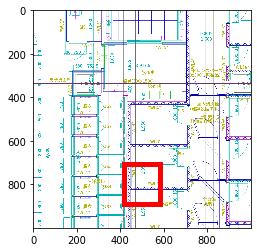

In [67]:
#img = skimage.io.imread("./images/" + im_name + ".jpg")
s3_clientobj = client.get_object(Bucket='label-test3', Key=img_file)

img = mpimg.imread(BytesIO(s3_clientobj['Body'].read()), 'jp2')

boxes = extract_boxes(img_file)
print("There are {count} objects in the image.".format(count=len(boxes)))
print("BBoxes:", boxes, end="\n\n")

fig, ax = matplotlib.pyplot.subplots()
ax.imshow(img)

for box_idx in range(len(boxes)):
    rect = matplotlib.patches.Rectangle((boxes[box_idx][0], boxes[box_idx][1]), 
                                        boxes[box_idx][2]-boxes[box_idx][0],
                                        boxes[box_idx][3]-boxes[box_idx][1], 
                                        linewidth=5, 
                                        edgecolor='r', 
                                        facecolor='none')
    ax.add_patch(rect)

matplotlib.pyplot.show()